__Нейросетевая языковая модель на основе Tranformer__

Евгений Борисов <esborisov@sevsu.ru>

---

Attention Is All You Need  (2017)    
https://arxiv.org/abs/1706.03762

Нейчев Радослав  Машинное обучение. 4. Self-Attention. Transformer overview. Лекторий ФПМИ, 2020   
https://www.youtube.com/watch?v=UETKUIlYE6g


ML: Attention - Механизм внимания    
https://qudata.com/ml/ru/NN_Attention.html
    
    
Jay Alamma  The Illustrated Transformer. 2020    
https://jalammar.github.io/illustrated-transformer/

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

%precision 3
np.set_printoptions(precision=2)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

# загружаем тексты

In [2]:
import gzip
import requests
from bs4 import BeautifulSoup

In [3]:
# url='http://lib.ru/NEWPROZA/LOBAS/taxisty.txt'
# text = BeautifulSoup(requests.get(url).text).get_text()
# with gzip.open('taxisty.txt.gz','wt') as f: f.write(text)

with gzip.open('taxisty.txt.gz','rt') as f: text = f.read()

text = text[1030:-7261].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:343])

символов:637765
---------------

Вы прилетели в  Нью-Йорк и  остановились  в  одном  из отелей, глядящих
окнами на Центральный парк.  Наутро по  приезде вы вышли из  отеля, вдохнули
полной грудью очищенный зеленью парка воздух  и,  взглянув на часы, --  пора
было начинать хлопотливый день, --  направились к  первому из  таксомоторов,
выстроившихся вереницей у подъезда.
    


In [4]:
# url='http://az.lib.ru/d/dostoewskij_f_m/text_0080.shtml'
# text = BeautifulSoup(requests.get(url).text).get_text()
# with gzip.open('dostoewskij.txt.gz','wt') as f: f.write(text)

# # with gzip.open('dostoewskij.txt.gz','rt') as f: text = f.read()

# text = text[2876:-664184].strip() # выкидываем заголовок и хвост страницы 
# print(f'символов:{len(text)}\n---------------\n'%())
# print(text[:355])

---

In [5]:
from tqdm.auto import tqdm
from itertools import chain
import numpy as np

In [6]:
from nltk import __version__ as nltk_version
print('nltk version:',nltk_version)

from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.util import ngrams

nltk version: 3.8.1


In [7]:
# !pip install torch

In [8]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

In [9]:
# !pip install torchtext

In [10]:
# import torchtext
# from torchtext.data import get_tokenizer

In [11]:
class SeqDataset(Dataset):
    
    def __init__( self, text, seq_len ):
        assert seq_len>1
        assert len(text)>1
        
        self._tokens = ['<UNK>','<EOS>',] # служебные токены "неизвестное слово", "конец последовательности"
        
        self._seq_len = seq_len # количество слов контекста слева 
        # выполняем токенизацию текста 
        self._sentences = [ 
            nltk_tokenize_word(s,language='russian') # разбиваем предложения на слова
            for s in tqdm(nltk_sentence_split(text,language='russian')) # режем текст на отдельные предложения
        ]
        # строим словарь
        self._vocabulary = self._build_vocabulary(self._sentences)
        # выкидываем короткие предложения, добавляем служебный токен "конец последовательности"
        self._sentences = [ s + [ '<EOS>' ] for s in self._sentences if len(s)> self._seq_len*2 ]
        # собираем n-граммы длинны context_len+1
        self._data = self._encode_ngrams( self._build_ngrams(self._sentences) )
        
    def _build_vocabulary(self,sentences):        
        # собираем токены (слова) из текста, добавляем служебные
        text_tokens = self._tokens + sorted( set(chain(*sentences))-set(self._tokens) ) 
        return { w:n for n,w in enumerate(text_tokens) } # строим словарь
    
    def _build_ngrams(self, sentences):
        return [ # нарезаем последовательности токенов на n-граммы
            ng for s in tqdm(sentences)  
               for ng in ngrams( s, self._seq_len*2 ) 
        ]
    
    def _encode_ngrams(self,ngrams): # заменяем токены в n-граммах на номера в словаре
        return torch.tensor([ self.encode(ng) for ng in tqdm(ngrams) ], dtype=torch.long ) 
    
    def encode(self,s): return [ # заменить в последовательности все токены на их номера в словаре
            self._vocabulary[w] if (w in self._vocabulary) else self._tokens['<UNK>']
            for w in s 
        ]
    
    def __getitem__(self, idx): # выдать элемент датасета номер idx
        return ( 
                self._data[idx,:self._seq_len], 
                self._data[idx,self._seq_len:], 
            )
    
#     def _num2vec(self,x): # заменяем номер слова на вектор [0,1] длинны в размер словаря
#         return F.one_hot( x, num_classes=len(self._vocabulary)).to( torch.float32 ) 

    # размер датасета
    def __len__(self): return len(self._data)
    
    @property
    def vocabulary(self): return self._vocabulary
    
    @property
    def sentences(self): return self._sentences
    
    @property
    def sequence_len(self): return self._seq_len

In [12]:
ds = SeqDataset( text=text, seq_len=9 )

  0%|          | 0/6650 [00:00<?, ?it/s]

  0%|          | 0/2153 [00:00<?, ?it/s]

  0%|          | 0/42365 [00:00<?, ?it/s]

In [13]:
display(len(ds)) # размер датасета
display(len(ds.sentences)) # количество предложений 
display(ds.sequence_len) # количество предложений 
display(len(ds.vocabulary)) # размер словаря
display(max(ds.vocabulary.values())) # максимальное значение индекса в словаре

42365

2153

9

24068

24067

In [14]:
assert len(ds.vocabulary)== max(ds.vocabulary.values())+1

In [15]:
ds[:2]

(tensor([[ 1859, 15093, 17127,  5759,  6227,  9212, 14092,    14,  4666],
         [15093, 17127,  5759,  6227,  9212, 14092,    14,  4666, 16003]]),
 tensor([[16003,  6747, 14465,  9008, 14581,  5239,  9159,    14,  4903],
         [ 6747, 14465,  9008, 14581,  5239,  9159,    14,  4903, 11749]]))

# модель

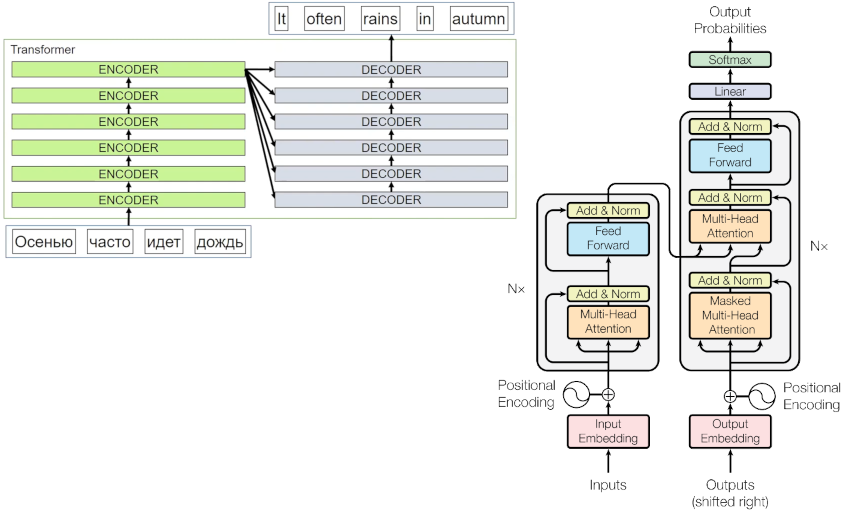

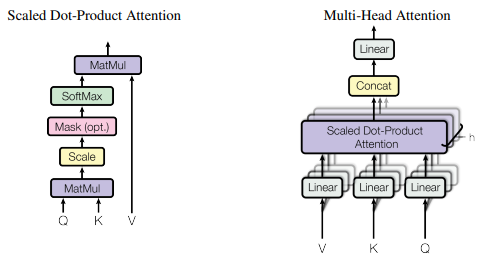

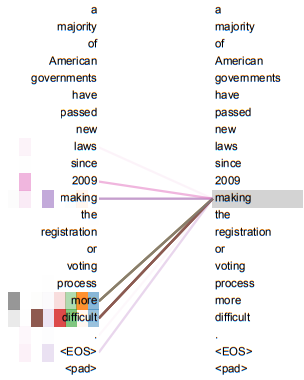

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
# n_samples = 2
# n_row = 3
# n_col = 4
# x = torch.rand(n_samples,n_row,n_col)
# y = torch.rand(n_samples,n_row,n_col)
# torch.bmm(x,y.transpose(1,2)) # barch matrix-matrix product 

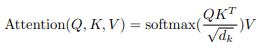

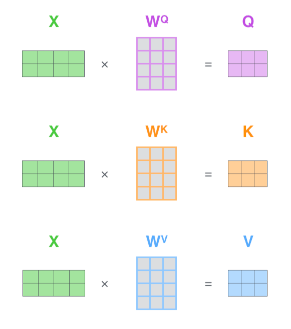

In [18]:
import math

class SelfAttention(nn.Module):
    
    def __init__(self,input_size,w_size):
        super().__init__()
        self._w_q = torch.normal(mean=0.,std=1e-5,size=(input_size,w_size))
        self._w_k = torch.normal(mean=0.,std=1e-5,size=(input_size,w_size))
        self._w_v = torch.normal(mean=0.,std=1e-5,size=(input_size,w_size))
        
    def forward(self,x):
        return self._attention(
                Q=torch.matmul( x, self._w_q),
                K=torch.matmul( x, self._w_k),        
                V=torch.matmul( x, self._w_v), 
            )
    
    def _attention(self,Q,K,V): 
        emb_size = Q.size(-1) # размерность эмбединга
        return torch.matmul( 
                F.softmax( 
                    torch.matmul(Q,K.T)/math.sqrt(emb_size)
                    ,dim=-1) 
                ,V 
            )

In [19]:
# n_samples, n_seq, emb_size, w_size = 2,3,4,5
# x = torch.rand(n_samples,n_seq,emb_size)
# x = x.reshape(n_samples,n_seq*emb_size)
# SelfAttention(emb_size*n_seq,w_size).forward(x).shape

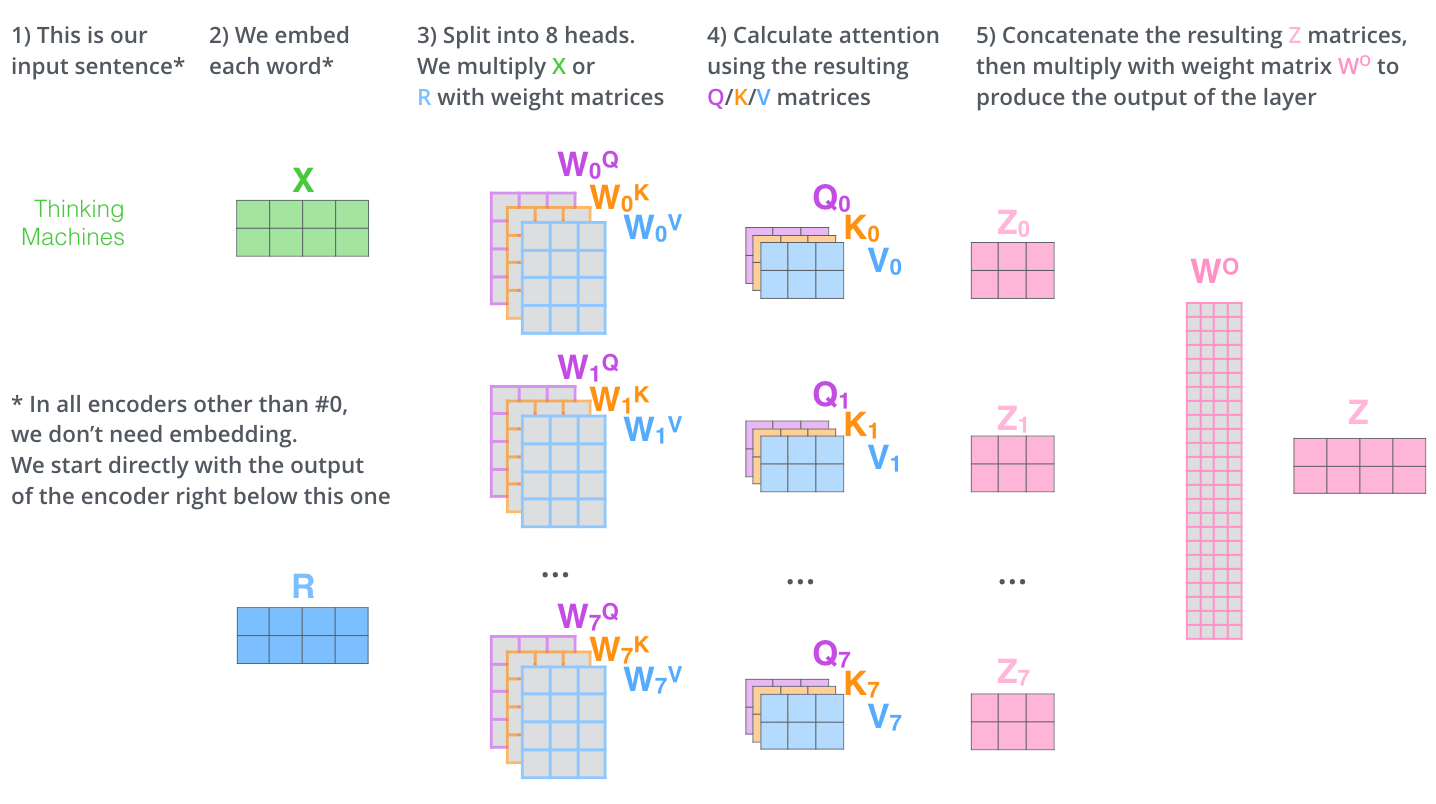

In [20]:
class MultiHeadedSelfAttention(nn.Module):
    
    def __init__(self, input_size, w_size, n_modules, output_size ):
        super().__init__()
        self._att = [ SelfAttention(input_size,w_size) for _ in range(n_modules) ]
        self._lin = nn.Linear( in_features=n_modules*w_size, out_features=output_size, bias=True, )
        
    def forward(self,x):
        # n_samples, seq_len, emb_size =  x.size()
        # x = x.reshape(n_samples,seq_len*emb_size)
        o = torch.cat([ a(x) for a in self._att ],dim=-1)
        o = self._lin(o)
        return o
            

In [21]:
# n_samples = 2
# seq_len,emb_size = 3,4
# w_size = 5
# n_modules = 7
# out_size = 9

# x = torch.rand(n_samples,seq_len,emb_size)
# # n_samples, seq_len, emb_size =  x.size()
# x = x.reshape(n_samples,seq_len*emb_size)

# o = MultiHeadedSelfAttention( 
#         input_size=seq_len*emb_size, 
#         w_size=w_size, 
#         n_modules=n_modules,
#         out_size=out_size,
#     ).forward(x) #.shape

# o.shape

## Positional encoding 

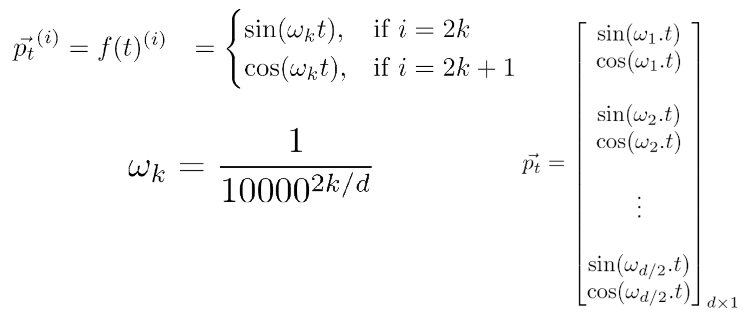

t – номер слова в строке;   
d – размерность входа модели;   
k – номер элемента в векторе PE;    

PE – не обучается вместе с моделью, но вычисляется по формуле 

длина последовательности ограничена 

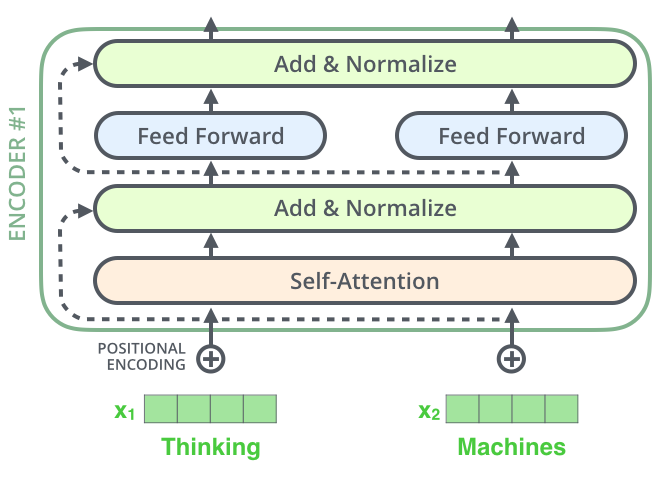

In [22]:
# a = np.ones((3,4),dtype=np.uint8)*np.array([[0,2,4]]).T
# b = np.ones((3,4),dtype=np.uint8)*np.array([[1,3,5]]).T
# np.hstack([a,b]).reshape(6,4)

In [23]:
class PositionalEncoding(nn.Module):
    
    def __init__( self, vector_size, seq_len ):
        super().__init__()
        t = torch.arange(seq_len,dtype=torch.float32).reshape(-1,1)
        w = lambda k,d: 1./10_000**(2.*k/d)
        w_even = w( torch.arange( start=0, end=vector_size,  step=2, dtype=torch.float32 ),vector_size )
        w_odd  = w( torch.arange( start=1, end=vector_size+1,step=2, dtype=torch.float32 ),vector_size )
        assert (len(w_odd)+len(w_even))==vector_size
        assert len(w_odd)==len(w_even)
        self._data = torch.hstack([torch.cos(w_even*t).T,torch.cos(w_odd*t).T, ]).reshape(vector_size,seq_len).T

    def forward(self,n):
        return self._data[n]

In [24]:
# PositionalEncoding(128,7)([2,3,4]).shape

---

In [26]:
class Encoder(nn.Module):
    
    def __init__(self, input_size=128, output_size=128, n_head=8, w_size=128 ):
        super().__init__()
        self._msa = MultiHeadedSelfAttention(
                input_size=input_size, 
                w_size=w_size, 
                n_modules=n_head, 
                output_size=output_size, 
            )
        
    def forward(self,x):
        o = self._msa(x)
        return o

---

In [27]:
class Transformer(nn.Module):
    
    def __init__(self, vocabulary, embedding_dim=128, seq_len=16, n_head=8, w_size=128 ):
        super().__init__()
        self._vocabulary = vocabulary
        self._emb = nn.Embedding(len(vocabulary),embedding_dim)
        self._pe = PositionalEncoding(vector_size=embedding_dim,seq_len=seq_len)
       
        self._encoder = Encoder(
                input_size=embedding_dim*seq_len, 
                output_size=embedding_dim*seq_len, 
                n_head=n_head, w_size=w_size 
            )
        
#         self._decoder = Dencoder(
#                 input_size=embedding_dim*seq_len, 
#                 output_size=embedding_dim*seq_len, 
#                 n_head=n_head, w_size=w_size 
#             )
        
    def forward(self,x):
        o = self._emb(x)
        n_samples, seq_len, emb_size = o.size()
        pe = self._pe(torch.arange(seq_len,dtype=torch.long)).unsqueeze(0)
        o = (o+pe).reshape(n_samples,seq_len*emb_size)
        o = self._encoder(o)
        return o        

In [28]:
x,t = ds[:2]
seq_len=x.size(-1)

Transformer(vocabulary=ds.vocabulary,seq_len=seq_len)(x).shape

# x,seq_len

torch.Size([2, 1152])

---

In [ ]:
# class Encoder(nn.Module):
#     def __init__(self, vocabulary, embedding_dim=128, hidden_dim=256,): 
#         super().__init__()
#         self._vocabulary = vocabulary
#         self._emb = nn.Embedding(len(vocabulary), embedding_dim)
#         self._gru = nn.GRU(
#                 input_size=embedding_dim, 
#                 hidden_size=hidden_dim, 
#                 num_layers=1, 
#                 batch_first=True,
#                 # dropout=0.4,
#             )

#     def forward(self, x):
#         o = self._emb(x)
#         o, h = self._gru(o)
#         return o,h

In [ ]:
# class Decoder(nn.Module):
    
#     def __init__(self, vocabulary, hidden_dim):
#         super(Decoder, self).__init__()
#         self._vocabulary = vocabulary
        
#         self._emb = nn.Embedding(num_embeddings=len(vocabulary),embedding_dim=hidden_dim)
#         self._gru = nn.GRU( 
#                 input_size=hidden_dim, 
#                 hidden_size=hidden_dim, 
#                 num_layers=1, 
#                 batch_first=True,
#                 # dropout=0.4,
#             )
#         self._lin = nn.Linear(in_features=hidden_dim, out_features=len(vocabulary),bias=True,)

#     # генерируем выход модели
#     def _forward_step(self,x,h):
#         o = self._emb(x)
#         o,h = self._gru(o,h)
#         o = self._lin(o)
#         o = F.log_softmax(o,dim=-1)
#         return o,h
    
#     # рабочий режим - по авторегрессионной схеме генерируем последовательность длиной seq_len
#     def forward(self, encoder_hidden, seq_len=10): 
#         device = next(self._lin.parameters()).device # устройство модели
#         batch_size = encoder_hidden.size(1) # размер входного батча 
#         codes = [] # выходная последовательность
#         h = encoder_hidden # состояние энкодера передаём декодеру
#         # начальный вход рекуррентного слоя
#         o = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
#         for i in range(seq_len):
#             o, h  = self._forward_step(o,h) # авторегрессионная схема - выход подаём на вход
#             o = torch.argmax(o,dim=-1, keepdim=False) # определяем номер токена-победителя
#             codes.append(o.cpu().numpy()) # сохраняем результат
#         return np.hstack(codes)
                
#     # учебный режим - генерируем последовательность длинной как у target
#     # по схеме teacher forcing, на каждой итерации заменяем вход на значение из target
#     def forward_train(self, encoder_hidden, target):
#         device = next(self._lin.parameters()).device # устройство модели
#         batch_size = encoder_hidden.size(1) # размер входного батча 
#         seq_len = target.size(-1) # длина учебной последовательности
        
#         outputs = []  # выходы модели 

#         # начальный вход рекуррентного слоя
#         t = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
#         h = encoder_hidden  # состояние энкодера передаём декодеру
        
#         for i in range(seq_len):
#             o, h = self._forward_step(t,h)
#             outputs.append(o)
#             # teacher forcing: заменяем выход модели на предыдущей итерации на target
#             t = target[:,[i]].to(device)
#         return torch.cat(outputs, dim=1)
    

In [ ]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

In [ ]:
embedding_dim = 128
encoder_hidden_dim = 256

model_encoder = Encoder(
        vocabulary=ds.vocabulary, 
        embedding_dim=embedding_dim,
        hidden_dim=encoder_hidden_dim,
    ).to(device)

model_decoder = Decoder( 
        vocabulary=ds.vocabulary, 
        hidden_dim=encoder_hidden_dim, 
    ).to(device)

In [ ]:
# x,t = ds[:2]
# with torch.set_grad_enabled(False): # генерируем следующий токен
#     _,h = Encoder(vocabulary=ds.vocabulary, embedding_dim=128, hidden_dim=256,).forward(x)
#     display(h.shape)
#     o = Decoder(vocabulary=ds.vocabulary, hidden_dim=256, ).forward_train(h,t)
#     display(o.shape)
#     c = Decoder(vocabulary=ds.vocabulary, hidden_dim=256,).forward(h)
#     display(c.shape)

# обучаем 

In [ ]:
from torch import optim

learning_rate = 1e-2
encoder_optimizer = optim.Adam( model_encoder.parameters(), lr=learning_rate )
decoder_optimizer = optim.Adam( model_decoder.parameters(), lr=learning_rate )
criterion = nn.NLLLoss()

In [ ]:
# история значений ф-ции потери
loss_history = [] 

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
%%time

n_epoch = 16 # количество эпох обучения
batch_size = 128

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    
    # получаем батч учебных примеров
    for encoder_input_, target in DataLoader( ds, batch_size=batch_size, shuffle=True): 
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        _, encoder_hidden = model_encoder(encoder_input_.to(device))
        decoder_outputs = model_decoder.forward_train( encoder_hidden, target )
        
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target.to(device).view(-1)
        )
        loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
   
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери


In [ ]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(loss_history)
ax.grid()
ax.set_title(f'min loss: {min(loss_history):.5f}')

# тестируем

In [ ]:
from random import sample
from nltk.util import ngrams 

prompts = [
    ' '.join(ng) 
    for s in sample( ds.sentences,10 ) if len(s)>ds.sentence_len*2
    for ng in list(ngrams(s[:ds.sentence_len],ds.sentence_len))  
    ]

display( prompts )

In [ ]:
class LangModelSeq2Seq: # генератор текста 
    
    def __init__(self,encoder,decoder,vocabulary):
        self._encoder = encoder 
        self._decoder = decoder 
        self._vocabulary = vocabulary # словарь языковой модели
        self._vocabulary_inv = { v:k for k,v in self._vocabulary.items() }
    
    def predict(self,prompt,seq_len=10):
        codes = self._predict( self._encode(prompt), seq_len) # генерируем коды токенов
        return self._strip_eos( self._decode(np.hstack(codes)) ) # конвертируем коды токенов в строку
    
    def _predict(self,x,seq_len):
        device = next(self._encoder.parameters()).device 
        with torch.set_grad_enabled(False): # генерируем следующий токен
            _,h = self._encoder(x.to(device))
            codes = self._decoder.forward(h,seq_len)
        return codes
    
    def _encode(self,s): # кодируем строку
        s = nltk_tokenize_word(s,language='russian')
        s = [ self._vocabulary[w] for w in s if (w in self._vocabulary) ]
        return torch.tensor([s], dtype=torch.long )
    
    def _decode(self,s): # конвертируем коды токенов в строку
        return ' '.join([ 
            self._vocabulary_inv[c] 
            for c in s if (c in self._vocabulary_inv) 
        ])
    
    @staticmethod
    def _strip_eos(s, eos = '<EOS>'):
        n = s.find(eos)
        return s if n<0 else s[:n+len(eos)]

In [ ]:
generator = LangModelSeq2Seq(model_encoder,model_decoder,ds.vocabulary)

for prompt in prompts:
    t = generator.predict(prompt,seq_len=35)
    print(prompt,'==>', t,'\n')